# Using Differential Privacy for Privacy-preserving Statistical Releases on Synthetic Suvery Data

<img src="https://drive.google.com/uc?id=1Qy42HQkEcVF3FM3nlod_9xZVKzU0ZR1f"  width=600/>

This notebook is aimed at demonstrating how to generate and release basic statistical outcomes in differentially private manner. 

Let's assume a data analyst has requested a trusted data curator for the following statistics (queries): 

**Single statistics**
- **Count of researchers** (concepts covered epsilon and sensitivity)
- **Sum of researchers' income** (concept covered clamping bounds)
- **Mean of researchers' income** (concept covered post-processing)

**Multiple statistics**
- **Histogram: count of researchers by sector** (concept covered parallel-composition)
- **Contingency table (or cross-tabulation): count of researchers by sector and academic degree** (concept covered parallel-composition) 

The data curator values the privacy of their survey participants, so they want to make sure that the data they release does not reveal anything about specific people. This is a perfect use case for differential privacy: it will allow us to publish useful insights about groups, while protecting data about individuals.

The noise added to the computation of a query can depend on the privacy parameters, the type of query, and the data itself. But in many cases, the result will still convey accurate insights about the original data. We wil learn the impact of:  
1. **Epsilon(ε)**: The privacy loss incurred by researchers in the dataset. Larger values indicate less privacy and more accuracy.
2. **Sensitivity**: The worst case change in a query's output when a row is removed/added. Noise scales with the sensitivity of a query.
3. **Clamping bounds**: Clipping the raw values to the set lower and upper bounds. Noise scales with the size of the bounds

With the above queries we will also be introduced to the concepts of **parallel composition** and **post-processing**.  

### Contents 

1. [Overview of Differential Private Mechanisms](#cell1)
    * 1.1. [Laplacian mechanism](#cell11)
    * 1.2. [Gaussian mechanism ](#cell12)
2. [Utility Functions](#cell2)
3. [Computing Queries Using Differential Privacy](#cell3)
    * 3.1. [Synthetic survey data](#cell31)
    * 3.2. [Count of researchers](#cell32)
        * 3.2.1. [Impact of epsilon](#cell321)
    * 3.3. [Sum of researchers' income](#cell33)
        * 3.3.1. [Impact of epsilon](#cell331)
        * 3.3.2. [Impact of clamping bounds](#cell332)
    * 3.4. [Mean of researchers' income (with post-processing)](#cell34)
    * 3.5. [Histogram: count of researchers by sector (with parallel composition)](#cell35)
    * 3.6. [Contingency table: count of researchers by sector and academic degree (with parallel composition)](#cell36)


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Overview of Differential Private Mechanisms <a id="cell1"></a>

For a better understanding of the **Laplace and Gaussian mechanisms** please refer to [this notebook]((https://github.com/dsaidgovsg/stack-2022-differential-privacy-workshop/blob/main/mechanisms.ipynb).

### 1.1. Laplace mechanism <a id="cell11"></a>

For a function ${f}(x)$ that output's a number for a query, **laplace mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + Lap(\frac{s}{\epsilon}$)

where **$s$** denotes sensitivtity and **$Lap(\frac{s}{\epsilon})$** denotes sampling a random value from the [laplacian distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with center 0 and scale $\frac{s}{\epsilon}$.

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$).

The laplacian mechanism satisfies the **$\epsilon$-differential privacy** i.e. pure-differential privacy, meaning, it provides worst case privacy gaurantee to the individuals in the dataset. 

In [3]:
def laplace_mechanism(query_out, sensitivity, epsilon):
    return query_out + np.random.laplace(loc=0, scale=sensitivity/epsilon)

### 1.2. Gaussian mechanism <a id="cell12"></a>

For a function ${f}(x)$ that output's a number for a query, **gaussian mechanism** $M(x)$ for ${\epsilon < 1}$ is given as: 

$M(x)= {f}(x) + \mathcal{N}(\sigma^{2})$

where $\sigma^{2} = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$

$\mathcal{N}(\sigma^{2})$ denotes sampling a random value from the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with center 0 and scale **$\sigma^{2}$**. 

$s$ is sensitivity  

𝛿 is the failue probability 
- with probability 1−𝛿, we will get the same guarantee as pure differential privacy;
- with probability 𝛿, we get no guarantee 

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$) and delta ($\delta$).

The gaussian mechanism satisfies the **$(\epsilon, \delta)$-differential privacy** i.e. approximate-differential privacy, meaning, it provides relaxed privacy gaurantee. 

In [4]:
def gaussian_mechanism(query, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return query + np.random.normal(loc=0, scale=sigma)

## 2. Utility Functions <a id="cell2"></a>

In [5]:
# function we will use to compute percentage absolute error 
def percentage_error(true_value, private_value):
    return round(abs(true_value - private_value)/true_value*100, 2)

In [6]:
# constants for the visualisations 
colors = ["#4CB7A5", "#0198E1", "#DE3163"]

# function we will use to visualise the impact of sensitivity, epsilon and clamping bounds
# on the accuracy of a query output
def visualise(dp_results, param, param_values, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    
    legend_labels = ['True value']
    for param_value, error in zip(param_values, errors):
        legend_labels.append(f"{param} = {str(param_value)} : Error = {str(round(error, 1))}%")

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = "Wistia")
    
    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## 3. Computing Queries Using Differential Privacy <a id="cell3"></a>

### 3.1. Synthetic survey data <a id="cell31"></a>

Now, we need to load our dataset, containing information about the researchers 

**Note**: You can refer to [the notebook](https://github.com/dsaidgovsg/stack-2022-differential-privacy-workshop/blob/main/generate_data.ipynb) on synthetic data generator. 

In [7]:
# loading data from google drive

# dataset with 500 rows
url='https://drive.google.com/file/d/1UmOb_GX7d2CuxLOj1wqAuhFM_gV9GREg/view?usp=share_link' # data with 500 rows

# +--------------------------------------------------------------------+
# You can uncomment and use a link to load the dataset of desired size
# +--------------------------------------------------------------------+
# data with 1000 rows
# url = 'https://drive.google.com/file/d/1o7SKjUGY71bVC77B_r4QEsP31agZyvyj/view?usp=share_link' 

# data with 10000 rows
# url = 'https://drive.google.com/file/d/1nkCfBcCdLoqtXqzw7ETG9BLt2xtWkfol/view?usp=share_link' 

url='https://drive.google.com/uc?id=' + url.split('/')[-2]

# loading data into pandas dataframe
data = pd.read_csv(url)

data_size = len(data)

print(f"Number of rows in the dataset {data_size}")
data.head(10)

Number of rows in the dataset 500


,NRIC,researcher_name,sector,income,degree
0,F7582445S,Richard Westfall,Aerospace,6527,Post-grad
1,F6351848Q,Brenda Tonn,Healthcare,8383,Non-degree
2,F0543228O,Juanita Cornwell,Agricultural,8298,Masters
3,G2869872L,Mary Lagasca,Engineering,3763,PhD
4,T0323244I,Frederick Patrick,Aerospace,13694,Masters
5,S8542460T,Paul Engler,Agricultural,3222,Masters
6,T3274897X,Frances Kinsler,Healthcare,4095,PhD
7,S8801177R,Leticia Fox,Healthcare,5191,Non-degree
8,S3833675A,Jose Higa,Healthcare,7598,Masters
9,G9347179L,Lionel Daily,Healthcare,5310,Masters


Great! Our dataset is ready for analysis. 😀

### 3.2. Count of researchers <a id="cell32"></a> 📊

--- 

We will count the researchers in the dataset who participated in the survey. We will also assume each researcher contributes to atmost one row. 

##### True count

In [8]:
# count of researchers is the number of rows
true_count = len(data['researcher_name'])

print("+----------------------------------+")
print(f"True count of the researchers: {true_count}")
print("+----------------------------------+")

+----------------------------------+
True count of the researchers: 500
+----------------------------------+


##### Private count 

We now allocate epsilon = 0.1 to count the researchers in a differentially private manner.   

As a rule of thumb, sensitivity of **count** query is 1. 

In [9]:
sensitivity = 1 

# +------------------------------------------------+
# You can play around with the epsilon value here
# +------------------------------------------------+
epsilon = 0.8

# applying laplacian mechanism
private_count = laplace_mechanism(true_count, sensitivity, epsilon)

print("+-------------------------------------------------------------------+")
print(f"Private count of the researchers: {private_count} with error: {percentage_error(true_count, private_count)}%")
print("+-------------------------------------------------------------------+")

+-------------------------------------------------------------------+
Private count of the researchers: 500.23158889960973 with error: 0.05%
+-------------------------------------------------------------------+


**Everytime you run the above lines of code, you might see different values! This is a central characteristic of differential privacy: it injects some randomisation (we call this noise) in the execution of the query.** 

#### 3.2.1. Impact of epsilon <a id="cell321"></a>

Now, we will visualise error with different values of epsilon. 

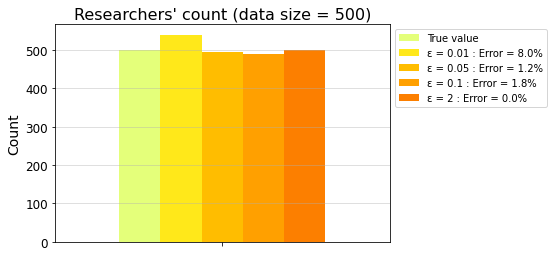

In [10]:
sensitivity = 1 

# +------------------------------------------------+
# You can play around with the epsilon values here 
# +------------------------------------------------+
epsilons = [0.01, 0.05, 0.1, 2]

# for visualisation
errors = []
dp_results = {}
dp_results["true_count"] = [true_count]

# evaluating on different values of epsilon
for epsilon in epsilons:
    # adding laplacian noise
    private_count = laplace_mechanism(true_count, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_count]
    errors.append(percentage_error(true_count, private_count))

# visualise data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

### 3.3. Sum of researchers' income <a id="cell33"></a> 📊
---

Counting query, which we ran is very useful, but we often need a little more: sums, averages, … We will see how to compute this larger class of aggregations with differential privacy. These operations require us to learn and use a new concept: **clamping bounds.** 

Sometimes we known a reasonable minimum and maximum for each value of a column, you can use those as clamping bounds e.g., age can have lower bound of 0 and an upper bound of 118.  It is simple to assume, without looking at the dataset, that all of the researchers in the survey are under the age of 118 and that ages must have a positive value.

Sometimes, things are not as clear-cut. Let's first explain what these clamping bounds do in order to understand what to do in more complicated situations.

#### Clamping bounds 
The data is clamped to be within lower and upper bounds in order to limit
the influence any one individual has on the query. 

$ f_{clamping}(x)= 
\begin{cases}
    upper,& \text{if } x\gt upper\\
    lower,& \text{if } x\lt lower\\
    x,              & \text{otherwise}
\end{cases}$

**What do clamping bounds actually do?** 🧐

These lower (minimum) and upper (maximum) values for numerical columns have direct affect on the value of the computed statistics, possibly dramatically. In particular, they have two major effects.

- The input data will be clamped within these bounds.
- The amount of noise in the data will (typically) increase with the size of the clamping bounds.

This is rational: the goal of differential privacy is to hide the influence of a single individual in the data, and clamping bounds limit that impact.

**Using distribution of researchers' income to estimate bounds** 

The total income for researchers is what we want to calculate. What are the proper clamping bounds?

Examining the most frequent values for this column is a common first step in making this choice. The following histogram gives us an idea of the data distribution.

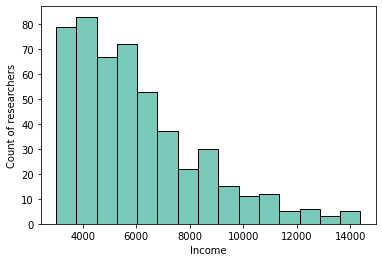

In [11]:
sns.histplot(data['income'], color=colors[0])
plt.xlabel('Income')
plt.ylabel('Count of researchers');

**Note**: It is usually acceptable to visualise the data distribution and make a judgment call, but it is not acceptable to take, for example, the exact maximum value in the data because doing so would reveal the value of a single data point.

##### True sum

In [12]:
true_sum_income = sum(data['income'])

print("+-----------------------------------------------------+")
print(f"True sum of the researchers' income: {true_sum_income}")
print("+-----------------------------------------------------+")

+-----------------------------------------------------+
True sum of the researchers' income: 3014194
+-----------------------------------------------------+


##### Bounded sum

In [13]:
# +------------------------------------------------+
# You can play around with the clamping bounds  here 
# +------------------------------------------------+
lower_bound = 4000
upper_bound = 13000

# apply clipping to the raw values to keep them within the set bounds
# - values less than `lower_bound` will be clipped to `lower_bound` 
# - values greater than `upper_bound` will be clipped to `upper_bound` 
data['bounded_income'] = data['income'].clip(lower=lower_bound, upper=upper_bound)

data[['income', 'bounded_income']].tail(20)

,income,bounded_income
480,3861,4000
481,5028,5028
482,3765,4000
483,10517,10517
484,14382,13000
485,5722,5722
486,4080,4080
487,6321,6321
488,4572,4572
489,5823,5823


In [14]:
# computing sum on the bounded values
true_bounded_sum_income = sum(data['bounded_income'])

print("+--------------------------------------------------------------+")
print(f"True bounded sum of the researchers' income: {true_bounded_sum_income}")
print("+--------------------------------------------------------------+")

+--------------------------------------------------------------+
True bounded sum of the researchers' income: 3058870
+--------------------------------------------------------------+


##### Private sum

In [15]:
# sensivity of the sum query in this case is the upper_bound
# reason: maximum the sum query's output will change on adding/removing a row is the `upper_bound`
sensitivity = upper_bound 

# +------------------------------------------------+
# You can play around with the epsilon value here 
# +------------------------------------------------+
epsilon = 0.8

# applying laplacian mechanism
private_sum_income = laplace_mechanism(true_bounded_sum_income, sensitivity, epsilon)

print("+-----------------------------------------------------------------------+")
print(f"Private sum of the researchers's income: {private_sum_income} with error: {percentage_error(true_sum_income, private_sum_income)}%")
print("+-----------------------------------------------------------------------+")

+-----------------------------------------------------------------------+
Private sum of the researchers's income: 3078311.6424102113 with error: 2.13%
+-----------------------------------------------------------------------+


#### 3.3.1. Impact of epsilon <a id="cell331"></a>

Now, we will visualise error with different values of epsilon. 

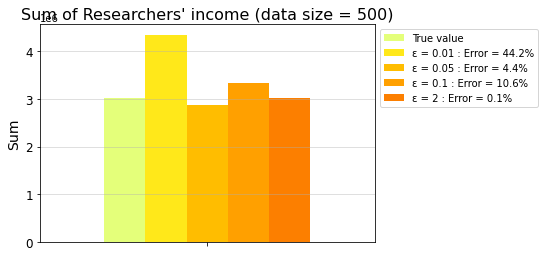

In [16]:
# +------------------------------------------------+
# You can play around with the epsilon values here 
# +------------------------------------------------+
epsilons = [0.01, 0.05, 0.1, 2]

# for visualisation
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_income]

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_sum_income = laplace_mechanism(true_sum_income, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_sum_income]
    errors.append(percentage_error(true_sum_income, private_sum_income))

# visualise data 
labels = [""]
title = f"Sum of Researchers' income (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

#### 3.3.2. Impact of clamping bounds <a id="cell332"></a>

Now, we will visualise error with different clamping bounds. 

---
If these bounds are too tight, the release may be biased, because values outside these bounds
are replaced with the nearest bound. On the other hand, if these bounds are too wide, the respective release will have greater variance.

---

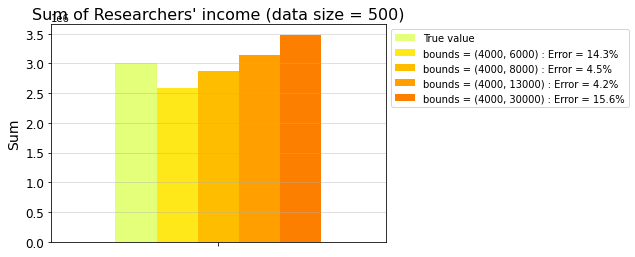

In [17]:
epsilon = 0.1

# +------------------------------------------------+
# You can play around with the clamping bounds here 
# +------------------------------------------------+
bounds = [(4000, 6000), (4000, 8000), (4000, 13000), (4000, 30000)]

# for visualisation
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_income]

# evaluating on different values of clamping bounds
for l, u in bounds:
    # setting sensitivity of the sum query as the `upper_bound`
    sensitivity = u

    # applying clamping 
    data['bounded_income'] = data['income'].clip(lower=l, upper=u)

    # sum of the bounded salaries
    true_bounded_sum_income = sum(data['bounded_income'])
    
    # applying laplace mechanism
    private_sum_income = laplace_mechanism(true_bounded_sum_income, sensitivity, epsilon)
    
    dp_results[f"bounds_{str(l)}_{str(u)}"] = [private_sum_income]
    errors.append(percentage_error(true_sum_income, private_sum_income))

# visualise data 
labels = [""]
title = f"Sum of Researchers' income (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'bounds', bounds, errors, ylabel, title, labels, (6, 4))

### 3.4. Mean of researchers' income (with post-processing) <a id="cell34"></a> 📊
---

We might be more interested in the mean income. Fortunately, we already have the differential private releases of the total number of researchers and their income, which we can use to calculate the mean. (Yay! No epsilon spending 😎)

A key feature of differential privacy is **post-processing**, which enables you to perform operations on differentially private releases without jeopardizing their privacy guarantee. The only obvious constraint is that you do not look at the original dataset. 👀

##### True mean

In [18]:
true_mean_income = true_sum_income/true_count

print("+--------------------------------------------------------+")
print(f"True mean of the researchers's income: {true_mean_income}")
print("+--------------------------------------------------------+")

+--------------------------------------------------------+
True mean of the researchers's income: 6028.388
+--------------------------------------------------------+


##### Private mean

In [19]:
# computing the private mean using the released private sum and count 
private_mean_income = private_sum_income/private_count

print("+----------------------------------------------------------------------------+")
print(f"Private mean of the researchers's income: {private_mean_income} with error: {percentage_error(true_mean_income, private_mean_income)}%")
print("+----------------------------------------------------------------------------+")

+----------------------------------------------------------------------------+
Private mean of the researchers's income: 6967.126645445499 with error: 15.57%
+----------------------------------------------------------------------------+


## Parallel composition 

The aggregates we observed, count, sum, and mean, returned a single statistic for all the data. However, a lot of frequently used data analysis operations are group-by queries, which partition the data into groups and calculate one aggregation per group.

Using **Parallel composition** instead of spending a privacy loss of k$\epsilon$ (with sequential composition -- epsilons add up on running multiple queries on a dataset), you only incur a privacy loss of $\epsilon$. Wow! 😮 


**Parallel composition** is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one chunk - so even if there are, say, k  chunks in total (and therefore k runs of the mechanism), the mechanism runs exactly once on the data of each individual. 



### 3.5. Histogram:  count of researchers by sector (with parallel composition) <a id="cell35"></a> 📊
---

We will assume that each researcher belongs to only one sector among Agricultural, Aerospace, Engineering and Healthcare.

Note: If a reseacher belongs to more than one sector than sensivity of the query will increase. Moreover, we need to apply bounds on the maximum sectors a researcher can belong to prevent scaling of the noise. 

##### **True** count of the researchers by sector

In [20]:
true_counts_by_sector = data['sector'].value_counts().to_frame()
true_counts_by_sector

,sector
Aerospace,144
Healthcare,127
Engineering,119
Agricultural,110


##### **Private** count of the researchers by sector

This analysis has a total privacy loss of the set epsilon value (in this case 1), even though we release many results

In [21]:
# sensitivity of the query is 1 
sensitivity = 1 

# +------------------------------------------------+
# You can play around with the epsilon value here 
# +------------------------------------------------+
epsilon = 0.8
# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
# adding noise
private_count_by_sector = data['sector'].value_counts().apply(add_laplace_noise)

private_count_by_sector.to_frame()

,sector
Aerospace,143.770220
Healthcare,126.139416
Engineering,118.006796
Agricultural,109.826815


#### Impact of epsilon on the query's output 

In [22]:
true_counts_by_sector_dict = dict(true_counts_by_sector['sector'])

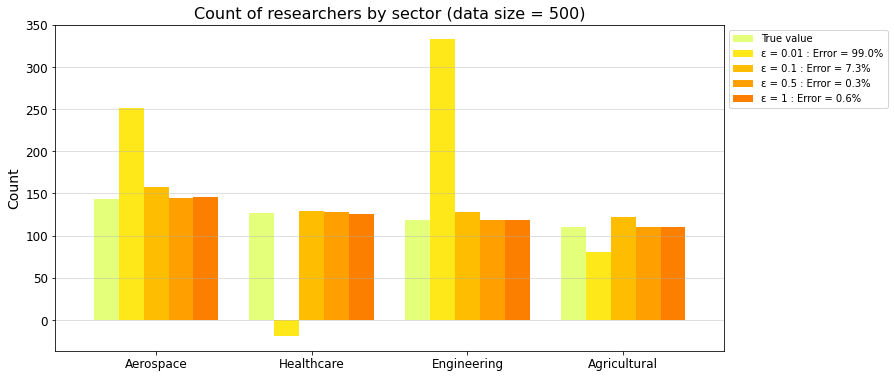

In [23]:
# +------------------------------------------------+
# You can play around with the epsilon values here 
# +------------------------------------------------+
epsilons = [0.01, 0.1, 0.5, 1]

# for visualisation
errors = []
dp_results = {}
true_counts_by_sector = true_counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_counts_by_sector = [laplace_mechanism(true_count, sensitivity, epsilon) for true_count in true_counts_by_sector]
    
    dp_results[f"epsilon_{epsilon}"] = private_counts_by_sector
    error = sum([percentage_error(tc, pc) for  tc, pc in zip(true_counts_by_sector, private_counts_by_sector)])/num_sectors
    errors.append(error)

# visualise data 
labels = true_counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"

visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (12, 6))

### 3.6. Contingency table: count of researchers by sector and academic degree (with parallel composition) <a id="cell36"></a> 📊
---

A contingency table or cross tabulation (often shortened to crosstab) is like a multi-dimensional histogram.

##### **True** count of the researchers by sector and academic degree

In [24]:
pd.crosstab(data['sector'], data['degree'])

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,27,36,27,30,24
Agricultural,20,13,23,28,26
Engineering,22,23,36,23,15
Healthcare,25,25,28,23,26


##### **Private** count of the researchers by sector and academic degree

In [25]:
sensitivity = 1 

# +------------------------------------------------+
# You can play around with the epsilon value here 
# +------------------------------------------------+
epsilon = 0.5

true_count_by_degree_and_sector = pd.crosstab(data['sector'], data['degree'])

# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
true_count_by_degree_and_sector.applymap(add_laplace_noise)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,24.942531,43.081124,23.614067,31.464817,23.403479
Agricultural,17.440872,12.827360,27.822482,27.058071,23.673984
Engineering,25.531286,17.943140,35.995639,24.099307,16.735882
Healthcare,29.178593,28.567575,32.743192,20.483161,30.762574
